In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import torch.nn as nn
import torch.optim as optim

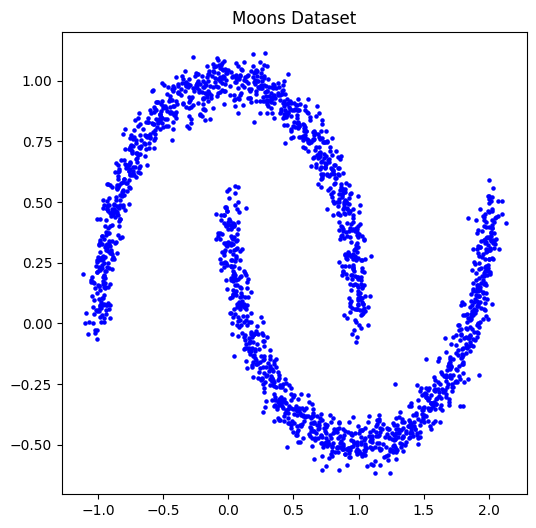

In [66]:
# Данные Moons, на которых мы будем обучаться
n_samples = 2000
X, _ = make_moons(n_samples=n_samples, noise=0.05)
X = torch.tensor(X, dtype=torch.float32)

# Визуализация данных
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=5, color='blue')
plt.title("Moons Dataset")
plt.show()

In [67]:
class AffineCouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AffineCouplingLayer, self).__init__()
        self.s_net = nn.Sequential(
            nn.Linear(input_dim , hidden_dim),
            nn.ReLU(),  # Вносим нелинейность в нашу модель для описания более сложных зависимостей
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()  # Ограничиваем s, чтобы e**(s) не принимало слишком большие значения
        )
        self.t_net = nn.Sequential(
            nn.Linear(input_dim , hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim )
        )# Здесь всё аналогично, только мы на выходе не ограничиваем значение t с помощью tanh

    def forward(self, x, mask):
        x1 = x * mask # Часть, которая останется неизменной
        x2 = x * (1 - mask) # Часть, которую мы будем трансформировать
        
        # Получаем параметры для сдвига и масштабирования
        s = self.s_net(x1)
        t = self.t_net(x1)
        
        # Аффинное преобразование
        x2 = x2 * torch.exp(s) + t
        
        # Объединение
        z = x1 + x2 * (1 - mask)
        
        # Вычисляем логарифм Якобиана, так как это просто сумма s
        log_det_jacobian = torch.sum(s, dim=1)
        
        return z, log_det_jacobian

    def inverse(self, z, mask):
        z1 = z * mask
        z2 = z * (1 - mask)
        
        s = self.s_net(z1)
        t = self.t_net(z1)
        
        # Обратное аффинное преобразование
        x2 = (z2 - t) * torch.exp(-s)
        
        # Объединение
        x = z1 + x2 * (1 - mask)
        
        return x


In [59]:
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(RealNVP, self).__init__()
        self.layers = nn.ModuleList([AffineCouplingLayer(input_dim, hidden_dim) for _ in range(num_layers)])
        
        # Создание чередующихся масок
        self.masks = [self.create_mask(input_dim, i % 2) for i in range(num_layers)]
    
    def create_mask(self, dim, even): # Pдесь мы создаем массив нулей и потом
        mask = torch.zeros(dim) # в зависимости от четности делаем нули единицами
        mask[::2] = 1 if even else 0
        mask[1::2] = 0 if even else 1
        return mask
    
    def forward(self, x):
        log_det_jacobian_total = 0
        for layer, mask in zip(self.layers, self.masks):
            x, log_det_jacobian = layer(x, mask)
            log_det_jacobian_total += log_det_jacobian
        return x, log_det_jacobian_total
    
    def inverse(self, z):
        for layer, mask in reversed(list(zip(self.layers, self.masks))):
            z = layer.inverse(z, mask)
        return z


In [60]:
def compute_loss(model, x):
    z, log_det_jacobian = model(x)

    # Расчёт логарифма плотности стандартного нормального распределения (так как мы считаем,
    # что после преобразовния мы получаем стандартное нормальное распределение)
    log_p_z = -0.5 * torch.sum(z ** 2, dim=1)

    # Общая вероятность
    log_p_x = log_p_z + log_det_jacobian

    # Возвращаем усредненный минус логарифм вероятности 
    return -torch.mean(log_p_x) # (минус потому что мы максимизируем логарифм, а функцию потерь минимизируем)

In [68]:
# Входные параметры
input_dim = 2
hidden_dim = 200
num_layers = 8

model = RealNVP(input_dim, hidden_dim, num_layers)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Обучение
n_epochs = 1000
for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = compute_loss(model, X)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 1.7445108890533447
Epoch 100, Loss: -8.80628776550293
Epoch 200, Loss: -9.209218978881836
Epoch 300, Loss: -9.340357780456543
Epoch 400, Loss: -9.425538063049316
Epoch 500, Loss: -9.461832046508789
Epoch 600, Loss: -9.484798431396484
Epoch 700, Loss: -9.495744705200195
Epoch 800, Loss: -9.50953197479248
Epoch 900, Loss: -9.524513244628906


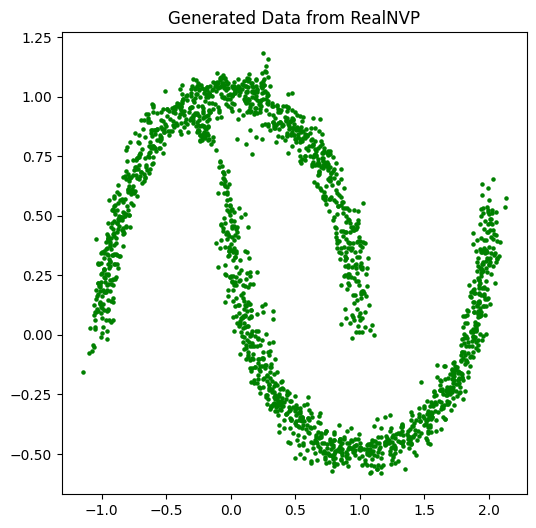

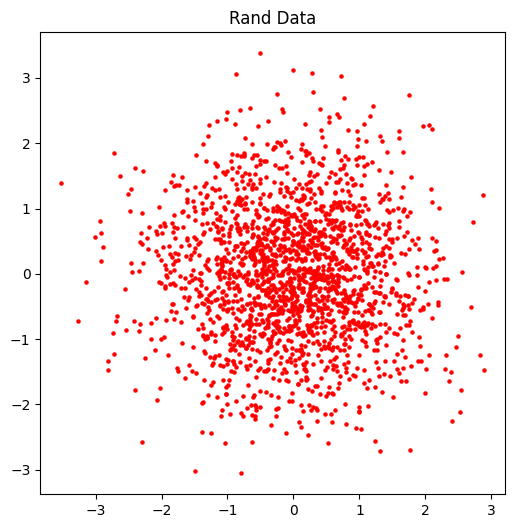

In [69]:
# Генерация новых данных
with torch.no_grad():
    z = torch.randn(n_samples, input_dim)
    generated_data = model.inverse(z)

# Визуализация
plt.figure(figsize=(6, 6))
plt.scatter(generated_data[:, 0], generated_data[:, 1], s=5, color='green')
plt.title("Generated Data from RealNVP")
plt.figure(figsize=(6, 6))
plt.scatter(z[:, 0], z[:, 1], s=5, color='red')
plt.title("Rand Data")
plt.show()